## Text Classification with RNN

In [0]:
!pip install --upgrade grpcio
!pip install tensorflow==2.0
!pip install tfds-nightly

In [0]:
%load_ext tensorboard

In [0]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [3]:
print(tf.__version__)

2.0.0


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

data_dir_path = 'gdrive/My Drive/tensorflow_datasets/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
tfds.disable_progress_bar()
train_validation_split = tfds.Split.TRAIN.subsplit([6, 4])
((train_dataset, validation_dataset), test_dataset), info = tfds.load('imdb_reviews/subwords8k', with_info=True, as_supervised=True, data_dir=data_dir_path, download=False, split=(train_validation_split, tfds.Split.TEST))

**[tfds.load()](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)** returns tf.data.Dataset and tf.core.DatasetInfo instances. 


[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) contains elements that have the same nested structure. The individual components of the structure can be of any type representable by [tf.TypeSpec](https://www.tensorflow.org/api_docs/python/tf/TypeSpec). tfds.load() returns all the splits (train, validation, and test) of the dataset if none is specified.

[tf.core.DatasetInfo](https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetInfo) documents the dataset info like name, version, features, url, citations, metadata etc. tfds.load() returns the information of the entire dataset if with_info=True, irrespective of the split requested. Split specific information is available in the splits attribute of the instance.




*tfds* includes a set of *TextEncoders* and *Tokenizers*.

[**TextEncoder**](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/TextEncoder) class in TensorFlow: Is an abstract base class for conversion between integers and text. Since text data has variable length and requires padding, ID 0 is always reserved for padding.

It has *vocab_size* as an attribute. vocab_size includes ID 0.

Method *encode()* encodes text into a list of integers. It never returns ID 0, and all IDs are always 1+.
Method *decode()* decodes a list of integers into text. It drops 0 in the input IDs.


[**SubwordTextEncoder**](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/text/SubwordTextEncoder) is an invertible TextEncoder using word pieces with a byte-level fallback. This encoding is fully invertible as all out-of-vocab wordpieces are byte-encoded. 

It contains *vocab_list* attribute which contains a list of subwords for the vocabulary. An underscore at the end of the vocabulary indicates the end of the word. Underscores in the interior of subword are disallowed and should be used with escape sequence.

**The dataset *info* includes the SubTextEncoder.**

In [55]:
print("info features: ", info.features)
encoder = info.features["text"].encoder
print("\n Vocabulary size: ", encoder.vocab_size)
print("\n Sample Subwords", encoder.subwords[10:20])

info features:  FeaturesDict({
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
})

 Vocabulary size:  8185

 Sample Subwords ['in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_']


As discussed above, the encoding is invertible.

In [56]:
sample_str = "IMDB Review Classification"
print("Original string: ", sample_str)

encoded_str = encoder.encode(sample_str)
print("Encoded string is: ", encoded_str)

decoded_str = encoder.decode(encoded_str)
print("Decoded string si: ", decoded_str)

for index in encoded_str:
    print("%s ----> %s"%(index, encoder.decode([index])))

Original string:  IMDB Review Classification
Encoded string is:  [5469, 7997, 2432, 3621, 739, 656, 2369, 1395, 3203, 757]
Decoded string si:  IMDB Review Classification
5469 ----> IM
7997 ----> D
2432 ----> B 
3621 ----> Rev
739 ----> ie
656 ----> w 
2369 ----> Cla
1395 ----> ssi
3203 ----> fic
757 ----> ation


### Preparing the dataset for training

We create batches of the encoded strings. **padded_batch** is used to zero pad the sequences to the length of the longest sequence in the batch. It combines consecutive elements of the dataset into padded batches.

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [85]:
print(dir(train_dataset))
# fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
# output_shapes returns the shape of each component of an element of this dataset.
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))

validation_dataset = validation_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(validation_dataset))

test_dataset = test_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_dataset))

['_GeneratorState', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_cache', '_abc_negative_cache', '_abc_negative_cache_version', '_abc_registry', '_add_variable_with_custom_getter', '_apply_options', '_as_serialized_graph', '_buffer_size', '_checkpoint_dependencies', '_component_metadata', '_consumers', '_deferred_dependencies', '_flat_shapes', '_flat_structure', '_flat_types', '_from_components', '_functions', '_gather_saveables_for_checkpoint', '_graph', '_graph_attr', '_handle_deferred_dependencies', '_has_captured_ref', '_input_dataset', '_inputs', '_is_graph_tensor', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', 

### Model

**[Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)** inherits from the base class Model, and groups a linear stack of layers into an object with training and inference features. 

**[Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)** inherits from the base class Layer and turns positive integer indices into vectors of fixed size. Takes as argument, input_dim (size of the vocabulary) and output_dim (dimension of the dense embedding).

In [86]:
n_hidden = 20

rnn_model = tf.keras.Sequential()
rnn_model.add(tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=64))
rnn_model.add(tf.keras.layers.SimpleRNN(units=n_hidden, activation='sigmoid'))
rnn_model.summary()

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 20)                1700      
Total params: 525,540
Trainable params: 525,540
Non-trainable params: 0
_________________________________________________________________


In [0]:
grads_sum = {'0':[], '1': [], '2': [], '3': []}

class GradHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
      with tf.GradientTape() as tape:
        loss = self.model(rnn_model.trainable_weights)
      x = tape.gradient(loss, rnn_model.trainable_weights)
      grads_sum['0'].append(np.sum(x[0]))
      grads_sum['1'].append(np.sum(x[1]))
      grads_sum['2'].append(np.sum(x[2]))
      grads_sum['3'].append(np.sum(x[3]))

gradient_cb = GradHistory()

In [0]:
callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  # tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='gdrive/My Drive/Colab Notebooks/DLCodeSnippets/tf_logs/rnn', histogram_freq=2, write_images=True, write_graph=True),
  # Log gradient history callback
  gradient_cb
]

In [0]:
# TODO: Run with new parameters
history = rnn_model.fit(train_dataset, epochs=20, validation_data=validation_dataset, validation_steps=10, callbacks=callbacks)

In [0]:
grads_sum

In [0]:
logsdirec = 'gdrive/My Drive/Colab Notebooks/DLCodeSnippets/tf_logs/rnn'

In [67]:
%tensorboard --logdir 'gdrive/My Drive/Colab Notebooks/DLCodeSnippets/tf_logs/rnn'

Reusing TensorBoard on port 6006 (pid 3106), started 0:00:58 ago. (Use '!kill 3106' to kill it.)

![alt text](images/rnn_params.png)

Plotting sum of gradients after each epoch. Should see constant sum if gradient vanishes.

[]

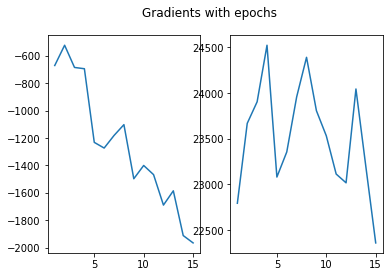

In [76]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Gradients with epochs')
ax1.plot(list(range(1,16)), grads_sum['1'])
ax2.plot(list(range(1,16)), grads_sum['2'])

plt.plot()

In [66]:
rnn_test_loss, rnn_test_acc = rnn_model.evaluate(test_dataset)
print("Accuracy on test set: ", rnn_test_acc)

391/391 [==============================] - 41s 104ms/step - loss: 0.6940 - accuracy: 0.5014
Accuracy on test set:  0.501408


![alt text](https://github.com/shruti-singh/DL-NLP/blob/master/images/SingleRNN.png?raw=1)